In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.optimizers import Adam

import numpy as np
from matplotlib import pyplot as plt

Below the dataset is imported. Mnist and fasion_mnist.

Shape of mnist_x_train (60000,32,28) and after normalizing and padding 
 (60000,32,32)

In [3]:
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
print(np.shape(mnist_x_train))
(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()
#normnalize in and pad
mnist_x_train = np.pad(mnist_x_train,((0,0),(2,2),(2,2)))/255.
print(np.shape(mnist_x_train))
mnist_x_test = np.pad(mnist_x_test,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_train = np.pad(fashion_mnist_x_train,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_test = np.pad(fashion_mnist_x_test,((0,0),(2,2),(2,2)))/255.

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
4431872/4422102 [==============================] - 0s 0us/step
(60000, 32, 32)


This is the generator function for train , test and validation set

In [4]:
def datagenerator(x1,x2,batchsize):
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)

        x_data = (x1[num1] + x2[num2]) / 2.0
        y_data = np.concatenate((x1[num1], x2[num2]), axis=2)

        yield x_data, y_data 

The input size taken for the desired model is (32,32,1)

In [5]:

inputShape = (32,32,1)

In [6]:
train_generator = datagenerator(mnist_x_train,fashion_mnist_x_train,16)
test_generator = datagenerator(mnist_x_test,fashion_mnist_x_test,16)
validation_generator = datagenerator(mnist_x_test,fashion_mnist_x_test,16)

This is the X_train image or the input image to the model


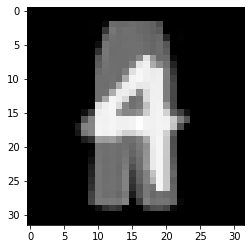

This is the desired output


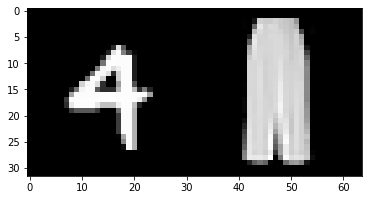

(32, 32)
(32, 64)
(16, 32, 32)


In [7]:
x, y = next(train_generator)
plt.imshow(x[0],cmap='gray', interpolation='nearest')
print("This is the X_train image or the input image to the model")
plt.show()
plt.imshow(y[0], cmap='gray', interpolation='nearest')
print("This is the desired output")
plt.show()

print(x[0].shape)
print(y[0].shape)
print(x.shape)

Below is the Diagram of the Model. SrCNN is basically used to denoise the image. So the idea is we take each image as the actual image another as noise and feed them to 2 SrCNN seperately. So each SrCNN will produce either the mnist image of digit or the fasion_minst image.
Then finally we concatenate them to a single image of 32*64.

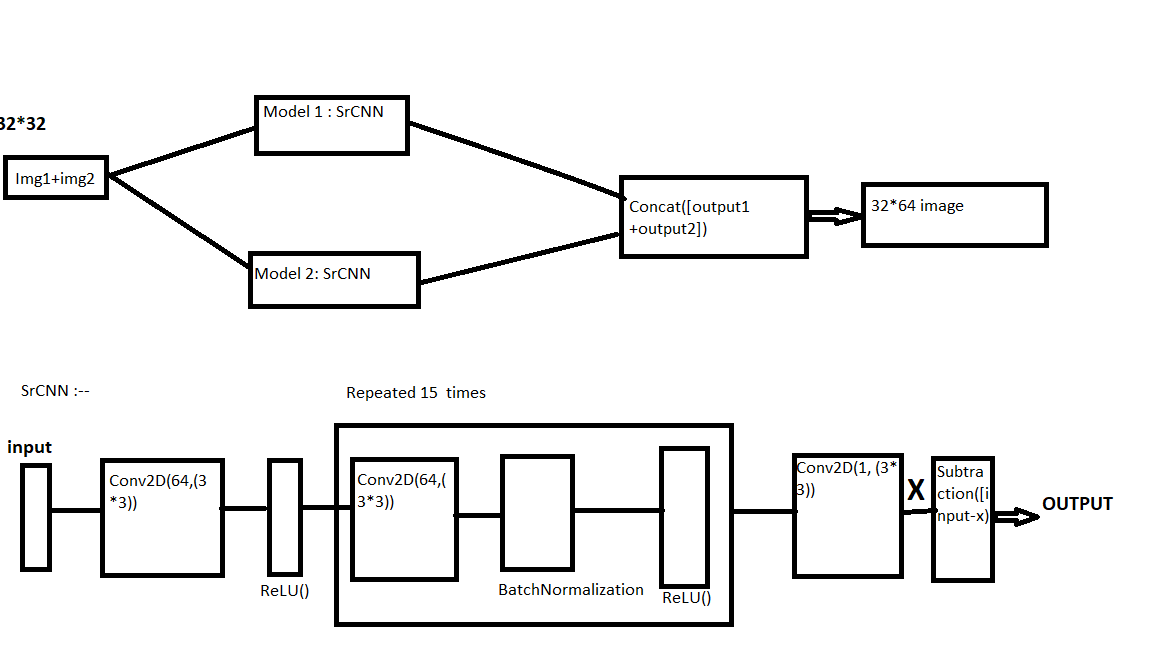

In [8]:
from tensorflow.keras.models import Model

input = layers.Input(shape=(32, 32, 1))

# Encoder
x = layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(input)
x = layers.ReLU()(x)
    # 15 layers, Conv+BN+relu
for i in range(15):
  x = layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)   
    # last layer, Conv
x = layers.Conv2D(filters=1, kernel_size=(3,3), strides=(1,1), padding='same')(x)
output1 = layers.Subtract()([input, x])

# Encoder
    # 1st layer, Conv+relu
x = layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(input)
x = layers.ReLU()(x)
    # 15 layers, Conv+BN+relu
for i in range(15):
  x = layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)   
    # last layer, Conv
x = layers.Conv2D(filters=1, kernel_size=(3,3), strides=(1,1), padding='same')(x)
output2 = layers.Subtract()([input, x])   # input - noise


y = layers.Concatenate(axis=2)([output1,output2])
# Autoencoder
autoencoder = Model(input, y)

autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   640         ['input_1[0][0]']                
                                                                                                  
 conv2d_17 (Conv2D)             (None, 32, 32, 64)   640         ['input_1[0][0]']                
                                                                                                  
 re_lu (ReLU)                   (None, 32, 32, 64)   0           ['conv2d[0][0]']                 
                                                                                              

In [9]:
autoencoder.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='mean_squared_error',
                 metrics=['mse','accuracy'])

Here in the model.fit() function we are using the data generator for the training and validation data. We are checking for 20000 samples in each epoch chosen randomly by the generator.

In [13]:
BATCH_SIZE = 16
N_EPOCHS = 20
hist = autoencoder.fit(train_generator,
              batch_size=BATCH_SIZE,
              epochs= N_EPOCHS,
              validation_data=validation_generator,
              steps_per_epoch = 20000,
              validation_steps= 20000,
              workers = 20,
              use_multiprocessing=True,
              shuffle=True)

Epoch 1/20
20000/20000 [==============================] - 748s 37ms/step - loss: 3.7487e-04 - mse: 3.7487e-04 - accuracy: 0.7422 - val_loss: 9.4113e-04 - val_mse: 9.4113e-04 - val_accuracy: 0.7407
Epoch 2/20
20000/20000 [==============================] - 747s 37ms/step - loss: 3.7125e-04 - mse: 3.7125e-04 - accuracy: 0.7416 - val_loss: 6.8323e-04 - val_mse: 6.8323e-04 - val_accuracy: 0.7408
Epoch 3/20
20000/20000 [==============================] - 749s 37ms/step - loss: 3.6510e-04 - mse: 3.6510e-04 - accuracy: 0.7416 - val_loss: 9.3602e-04 - val_mse: 9.3602e-04 - val_accuracy: 0.7408
Epoch 4/20
20000/20000 [==============================] - 748s 37ms/step - loss: 3.4555e-04 - mse: 3.4555e-04 - accuracy: 0.7416 - val_loss: 6.7452e-04 - val_mse: 6.7452e-04 - val_accuracy: 0.7408
Epoch 5/20
20000/20000 [==============================] - 748s 37ms/step - loss: 3.3401e-04 - mse: 3.3401e-04 - accuracy: 0.7418 - val_loss: 6.5011e-04 - val_mse: 6.5011e-04 - val_accuracy: 0.7408
Epoch 6/20
2000

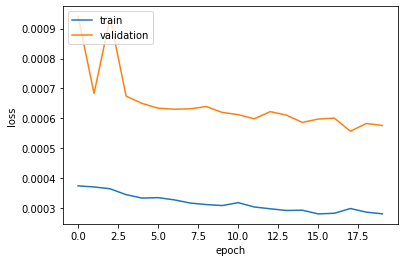

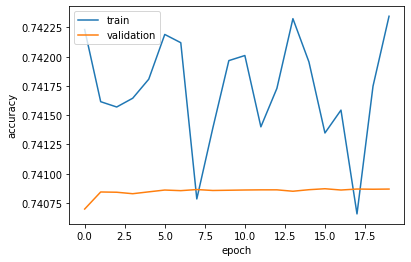

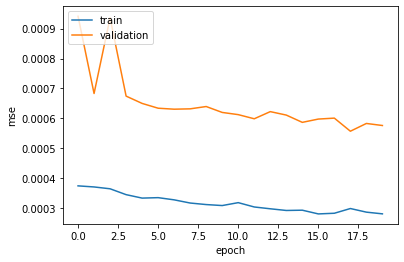

In [14]:
import matplotlib.pyplot as plt

def plot_history(model_history,keys):
    m,val_m = keys
    plt.plot(model_history.history[m])
    plt.plot(model_history.history[val_m])
    plt.ylabel(m)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

#plot_history(hist,['mse','val_mse'])
plot_history(hist,['loss','val_loss'])
plot_history(hist,['accuracy','val_accuracy'])
plot_history(hist,['mse','val_mse'])

In [15]:
y_pred = autoencoder.predict(test_generator,steps=20000)
print(y_pred.shape)

(320000, 32, 64, 1)


Below is the Y_pred---------


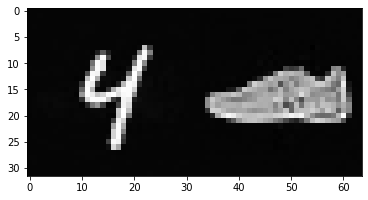

In [16]:

print("Below is the Y_pred---------")
plt.imshow(y_pred[0].reshape(32, 64),cmap='gray', interpolation='nearest')
plt.show()



Saving the weights

In [17]:
autoencoder.save('/weights/bss.h5')

Below we are storing the mse into an array. For evaluation we are taking 20000 samples chosen randomly and looped for 10 times. Then we are calculating the mean mse value and the standard deviation.

In [18]:
mse = np.zeros(10)
for i in range(10):
  mse[i] = autoencoder.evaluate(test_generator,steps=20000)[1]

mean_mse = mse.mean()
std = mse.std()





20000/20000 [==============================] - 268s 13ms/step - loss: 5.7648e-04 - mse: 5.7648e-04 - accuracy: 0.7407


In [ ]:
print(autoencoder.evaluate(test_generator,steps=20000))

print("Mean mse: ",mean_mse)

print("Standard deviation : ",std)

20000/20000 [==============================] - 184s 9ms/step - loss: 4.6060e-04 - mse: 4.6060e-04 - accuracy: 0.7405
[0.00046059826854616404, 0.00046059826854616404, 0.7405388355255127]
Mean mse:  0.0004605915426509455
Standard deviation :  1.1688079199301461e-06
